<a href="https://colab.research.google.com/github/a-fokina/transcriptomics/blob/homework-2/HW2_Fokina_Anastasia_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Домашняя работа 2.ЕМ-алгоритм и подсчет числа прочтений.
###Задание 1
Сделайте NextFlow пайплайн, который будет подсчитывать принимать на вход аргументом список SRA-идентефикаторов эксперимента, а на выход давать подсчитанные экспрессии. Путь к индексу kallisto тоже будет подаваться на вход отдельно как аргумент.

Загрузим необходимые пакеты и программы.

In [ ]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz

In [ ]:
!sratoolkit.3.0.0-ubuntu64/bin/vdb-config -i

In [ ]:
!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.11.9.zip
!unzip fastqc_v0.11.9.zip

In [ ]:
!chmod +x FastQC/fastqc

In [ ]:
!pip3 install multiqc

In [ ]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

In [ ]:
! gdown https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_rna.fna.gz

In [ ]:
!./kallisto/build/src/kallisto index -i transcriptome.idx GRCh38_latest_rna.fna.gz

Запустим скрипт hw2_pipeline.nf для анализа качества прочтений и подсчета экспрессии.

In [ ]:
!./nextflow run hw2_pipeline.nf -with-report nextflow_report.html -with-dag flowchart.pdf --file sra.txt --infile /content/reads.fastq --work-dir /content/homework_2 --results_dir /content/homework_2 --i /content/transcriptome.idx

Запустим скрипт hw2_pipeline_single.nf для анализа качества и подсчета экспрессии одноконцевых прочтений.

In [ ]:
!./nextflow run hw2_pipeline.nf -with-report nextflow_report.html -with-dag flowchart.pdf  --file sra.txt --infile /content/reads.fastq  --results_dir /content/homework_2 --i /content/transcriptome.idx --s 1 --l 100

### Задание 2
Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных.

In [ ]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk #загружаем датасет

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 16.8MB/s]


Визуализируем полученный датасет

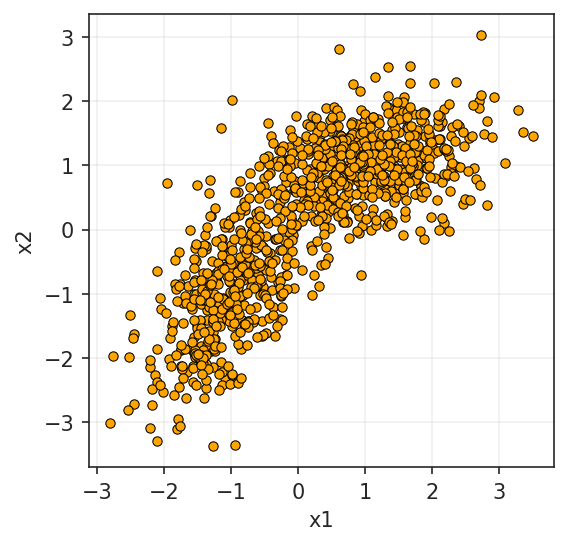

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=20, edgecolor="black", linewidth=0.5, ax=ax, color = "orange")
ax.grid(alpha=0.3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


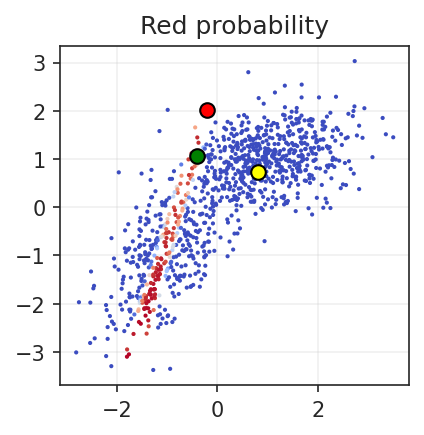

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


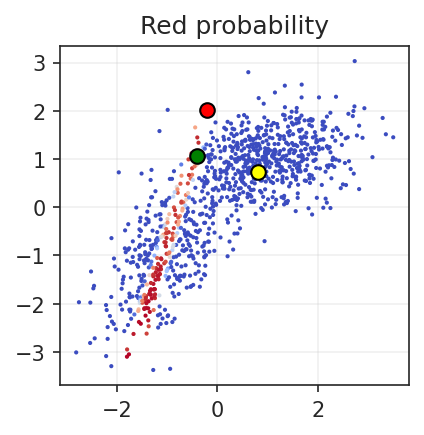

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


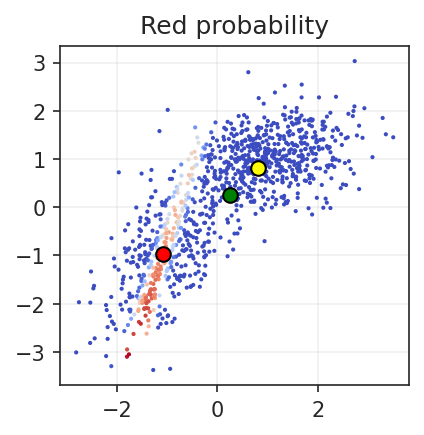

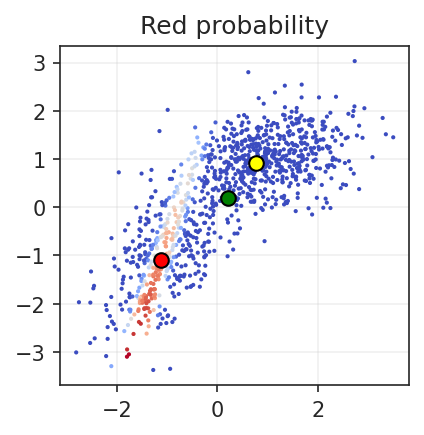

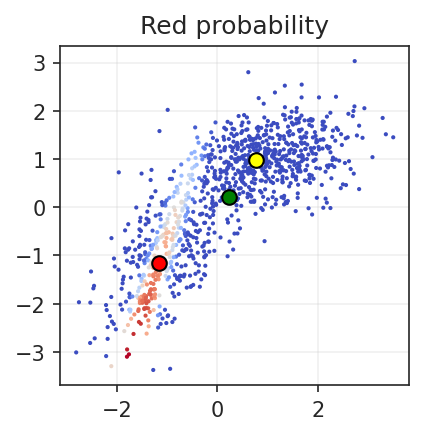

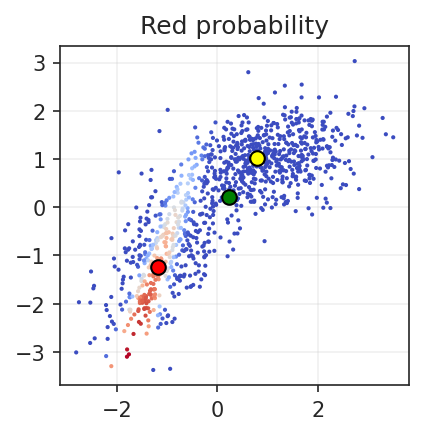

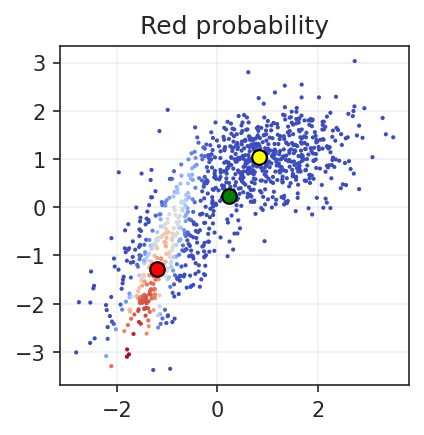

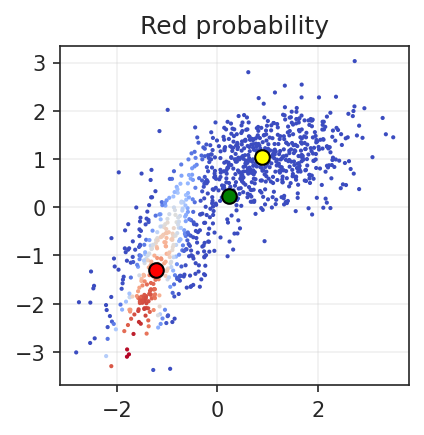

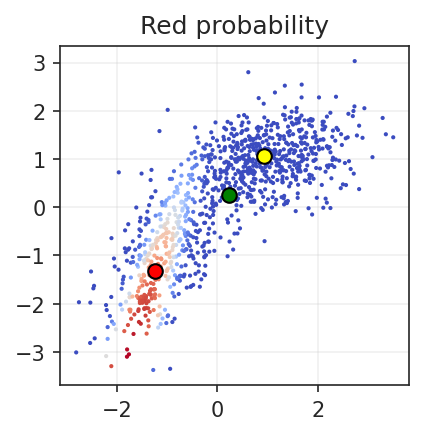

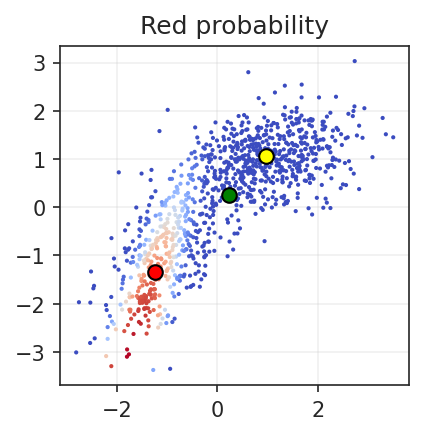

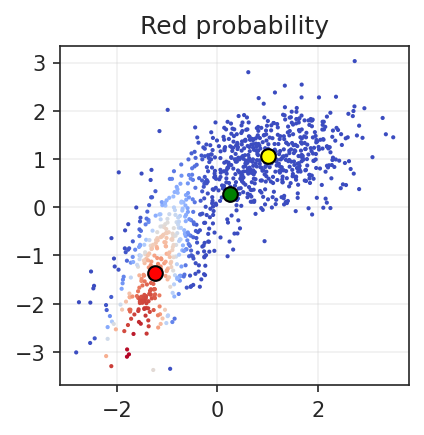

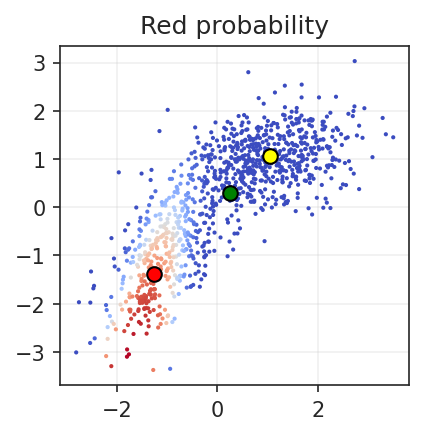

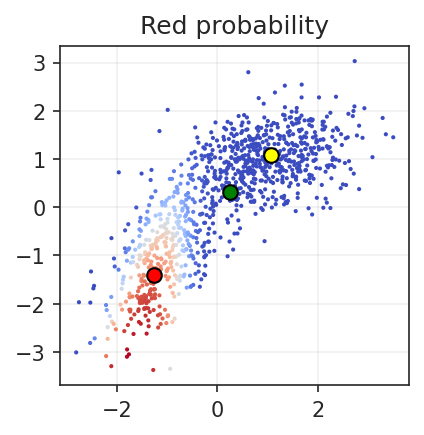

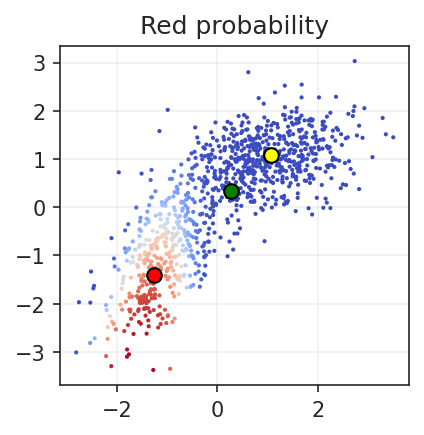

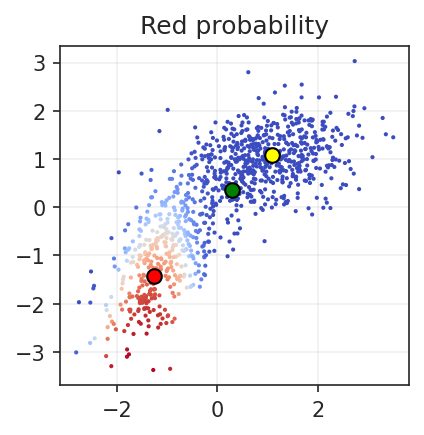

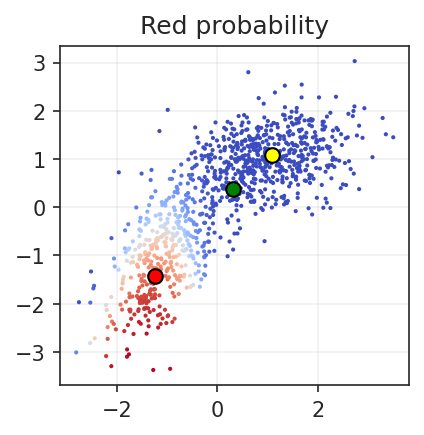

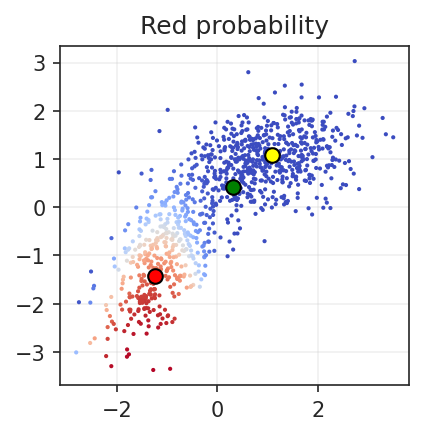

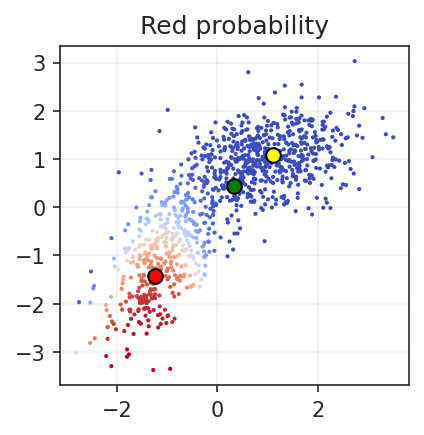

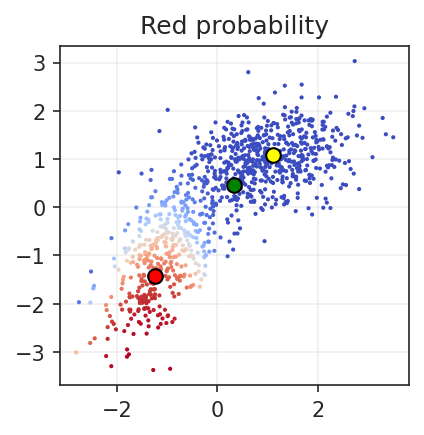

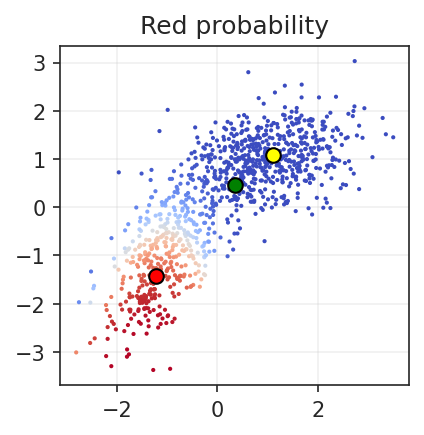

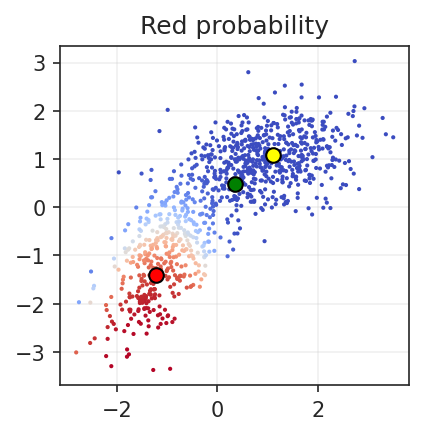

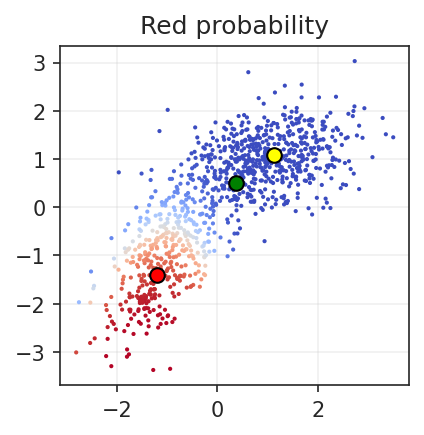

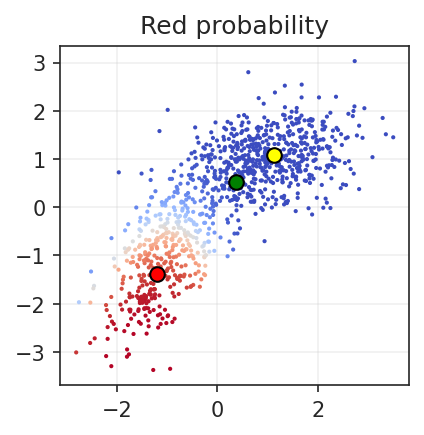

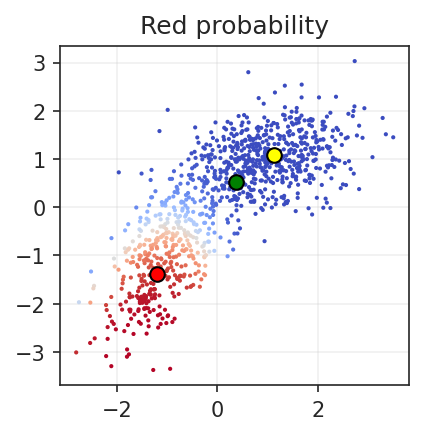

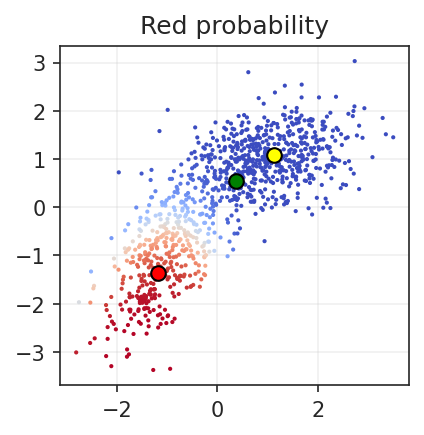

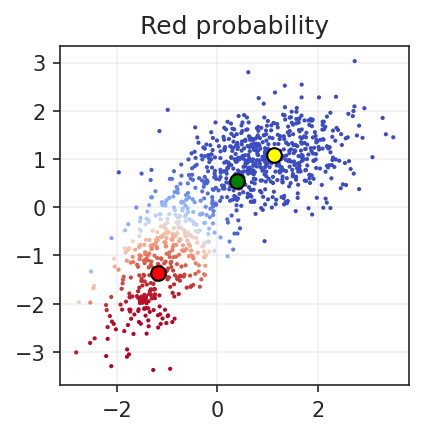

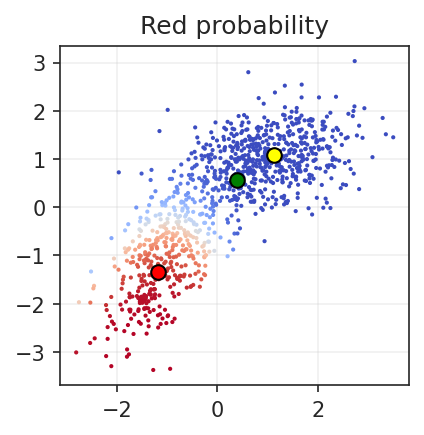

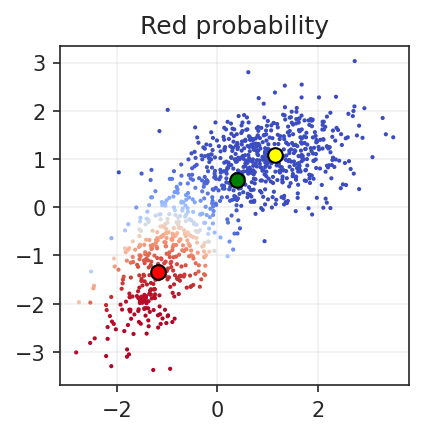

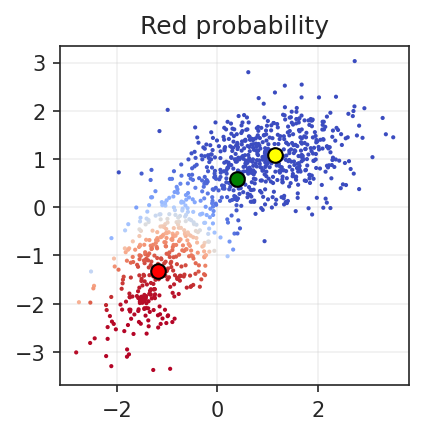

In [ ]:
import numpy as np

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())
#Получим изначальные параметры для дальнейшей оптимизации
params = {
    "phi1" : np.random.uniform(0, 0.33333),
    "phi2" : np.random.uniform(0, 0.33333),

    "mu1" : np.random.normal(0, 1, size=2),
    "mu2" : np.random.normal(0, 1, size=2),
    "mu3" : np.random.normal(0, 1, size=2),
    
    "sigma1": get_random_psd(),
    "sigma2" : get_random_psd(), 
    "sigma3" : get_random_psd() 
}

#На E-шаге мы будем для каждой точки считать постериорные log(Likelihood)'ы принадлежности каждой из точек к тому или иному кластеру.
import scipy.stats as stats
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogProb = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X),
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])

  logPrior = np.log([(1 - params["phi1"] - params["phi2"]), params["phi2"],params["phi1"]])
  logPosterior = logPrior + LogProb.T
  RealSoftMax = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)
  if draw:
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0, palette="coolwarm", ax=ax, s=4)
    ax.plot(params["mu1"][0], params["mu1"][1], marker="o", markersize=7, color="red", markeredgewidth=1, markeredgecolor="black")
    ax.plot(params["mu2"][0], params["mu2"][1], marker="o", markersize=7, color="green", markeredgewidth=1, markeredgecolor="black")
    ax.plot(params["mu3"][0], params["mu3"][1], marker="o", markersize=7, color="yellow", markeredgewidth=1, markeredgecolor="black")
    ax.set_title("Red probability")
    ax.grid(alpha=0.3)
    ax.legend().remove()
    plt.show()
  return RealSoftMax, probabilities
loglikelihood, probabilities = E_step(X, params, draw=True)
np.shape(probabilities)

#На М-шаге оптимизируем параметры в зависимости от того, как были определены принадлежности точек к кластерам на предыдущем шаге
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)

  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)
  
  return {
      "phi1" : phi1, "phi2" : phi2, 
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }
#Повторять оптимизацию, пока LogLikelihood не перестанет уменьшаться меньше, чем на 0.0001.
def run_EM(X, params, draw=False):
    import imageio
    avg_loglikelihoods = []

    while True:
        loglikelihood, probabilities = E_step(X, params, draw=draw)
        avg_loglikelihoods.append(np.mean(loglikelihood))
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.000691:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_loglikelihoods
pred, prob, loglikelihoods = run_EM(X, params, draw=True)

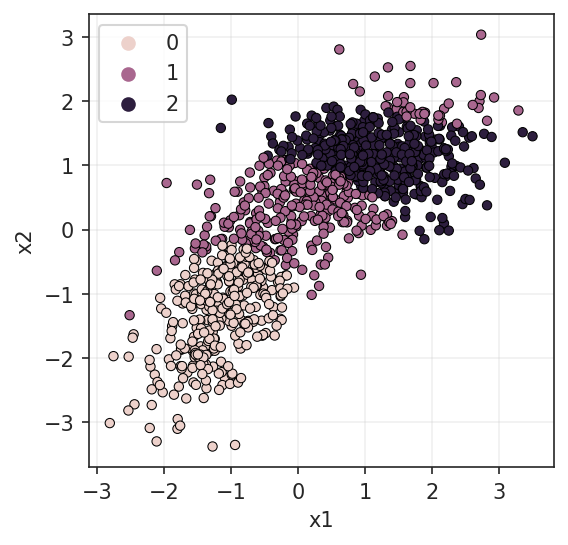

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=20, edgecolor="black", linewidth=0.5, ax=ax, hue=pred)
ax.grid(alpha=0.3)

Судя по тому, что результат разбиения на кластеры не воспроизводится, в моем коде есть некоторые ошибки. Кроме того, невоспроизводимость результата может быть объяснена тем, что данные разбиваются на два кластера, а однозначно разбит

###Задание 3
Попробуйте сами написать алгоритм, который будет при помощи EM-алгоритма оценивать представленность экспрессию транскриптов (необязательно работать с графами или прочтениями, можете упростить ситуацию до модельной).